<a href="https://colab.research.google.com/github/k2m5t2/tvm-scratchbook/blob/main/faster_rcnn_from_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Compile PyTorch Models
**Author**: [Yunho Cho](https://github.com/k2m5t2/)

### Setup

In [1]:
%%shell
# Installs the latest dev build of TVM from PyPI. If you wish to build
# from source, see https://tvm.apache.org/docs/install/from_source.html
pip install apache-tvm --pre

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 7.5 MB/s eta 0:00:00


In [26]:
# basics
import numpy as np
from PIL import Image
import cv2

# tvm
import tvm
from tvm import relay
from tvm.contrib.download import download_testdata

# pytorch
import torch
import torchvision
from torchvision import transforms

from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

# Faster R-CNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

## Load a pretrained PyTorch model



In [3]:
# Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:03<00:00, 46.3MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [11]:
input_tensor = torch.randn(1, 3, 224, 224)  # Start with a common input size for many torchvision models

try:
    with torch.no_grad():
        output = model(input_tensor)
    print("Model accepted input of shape:", input_tensor.shape)
except RuntimeError as e:
    print(e)  # This will print the error message, which usually has useful shape information

Model accepted input of shape: torch.Size([1, 3, 224, 224])


In [13]:
def do_trace(model, inp):
    model_trace = torch.jit.trace(model, inp)
    model_trace.eval()
    return model_trace


def dict_to_tuple(out_dict):
    if "masks" in out_dict.keys():
        return out_dict["boxes"], out_dict["scores"], out_dict["labels"], out_dict["masks"]
    return out_dict["boxes"], out_dict["scores"], out_dict["labels"]


class TraceWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inp):
        out = self.model(inp)
        return dict_to_tuple(out[0])

In [23]:
# We grab the TorchScripted model via tracing
input_shape = [1, 3, 224, 224]
in_size = input_shape[-1]
input_data = torch.randn(input_shape)
with torch.jit.optimized_execution(True):
    scripted_model = torch.jit.trace(TraceWrapper(model), input_data).eval()
    # scripted_model = torch.jit.script(model, input_data).eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3912: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/usr/local/lib/python3.10/dist-packages/torchvision/ops/boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/usr/local/lib/python3.10/dist-packages/torchvision/ops/boxes.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bo

### Initialize preprocess

In [6]:
# # Preprocess the image and convert to tensor

# my_preprocess = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]
# )

# Initialize the inference transforms
preprocess = weights.transforms()

## Load a test image


In [7]:
# img = read_image("test/assets/encode_jpeg/grace_hopper_517x606.jpg")

img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))

img_ = preprocess(img)
batch = [img_]

## Import the graph to Relay
Convert PyTorch graph to Relay graph. The input name can be arbitrary.



In [16]:
scripted_model

TraceWrapper(
  original_name=TraceWrapper
  (model): FasterRCNN(
    original_name=FasterRCNN
    (transform): GeneralizedRCNNTransform(original_name=GeneralizedRCNNTransform)
    (backbone): BackboneWithFPN(
      original_name=BackboneWithFPN
      (body): IntermediateLayerGetter(
        original_name=IntermediateLayerGetter
        (conv1): Conv2d(original_name=Conv2d)
        (bn1): BatchNorm2d(original_name=BatchNorm2d)
        (relu): ReLU(original_name=ReLU)
        (maxpool): MaxPool2d(original_name=MaxPool2d)
        (layer1): Sequential(
          original_name=Sequential
          (0): Bottleneck(
            original_name=Bottleneck
            (conv1): Conv2d(original_name=Conv2d)
            (bn1): BatchNorm2d(original_name=BatchNorm2d)
            (conv2): Conv2d(original_name=Conv2d)
            (bn2): BatchNorm2d(original_name=BatchNorm2d)
            (conv3): Conv2d(original_name=Conv2d)
            (bn3): BatchNorm2d(original_name=BatchNorm2d)
            (relu): R

In [19]:
input_name = "input0"
# shape_list = [(input_name, img_.shape)]
shape_list = [(input_name, input_shape)]
mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)

In [28]:
img_url = (
    "https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/detection/street_small.jpg"
)
img_path = download_testdata(img_url, "test_street_small.jpg", module="data")

img = cv2.imread(img_path).astype("float32")
img = cv2.resize(img, (in_size, in_size))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.transpose(img / 255.0, [2, 0, 1])
img = np.expand_dims(img, axis=0)

In [ ]:
# Step 4: Use the model and visualize the prediction
# prediction = model(batch)[0]
prediction = model(torch.from_numpy(img))[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]

In [43]:
box = draw_bounding_boxes(torch.from_numpy((img*256).astype(np.uint8))[0], boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im.show()

/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:232: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


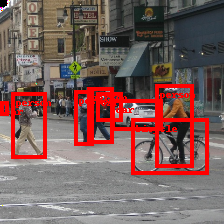

In [50]:
im

In [41]:
torch.from_numpy((img*256).astype(np.uint8)).shape

torch.Size([1, 3, 224, 224])

## Relay Build
Compile the graph to llvm target with given input specification.



In [46]:
# Add "-libs=mkl" to get best performance on x86 target.
# For x86 machine supports AVX512, the complete target is
# "llvm -mcpu=skylake-avx512 -libs=mkl"
target = "llvm"

with tvm.transform.PassContext(opt_level=3, disabled_pass=["FoldScaleAxis"]):
    vm_exec = relay.vm.compile(mod, target=target, params=params)

In [47]:
# target = tvm.target.Target("llvm", host="llvm")
# dev = tvm.cpu(0)
# with tvm.transform.PassContext(opt_level=3):
#     lib = relay.build(mod, target=target, params=params)

## Execute the portable graph on TVM
Now we can try deploying the compiled model on target.



In [ ]:
# from tvm.contrib import graph_executor

# dtype = "float32"
# m = graph_executor.GraphModule(lib["default"](dev))
# # Set inputs
# m.set_input(input_name, tvm.nd.array(img.astype(dtype)))
# # Execute
# m.run()
# # Get outputs
# tvm_output = m.get_output(0)

In [49]:
from tvm.runtime.vm import VirtualMachine
dev = tvm.cpu()
vm = VirtualMachine(vm_exec, dev)
vm.set_input("main", **{input_name: img})
tvm_res = vm.run()

In [58]:
tvm_res[0]

<tvm.nd.NDArray shape=(8, 4), cpu(0)>
array([[1.14748774e+01, 9.29637451e+01, 4.60682144e+01, 1.58609161e+02],
       [1.31462143e+02, 1.18979637e+02, 2.08951797e+02, 1.74730743e+02],
       [1.55672668e+02, 8.46872025e+01, 1.93743652e+02, 1.67232513e+02],
       [1.11028305e+02, 9.90307465e+01, 1.62505615e+02, 1.30148941e+02],
       [7.44358368e+01, 9.04601440e+01, 9.39797134e+01, 1.45087402e+02],
       [8.73177338e+01, 8.78897171e+01, 1.13082916e+02, 1.43997055e+02],
       [1.01673892e-02, 1.01236244e+02, 8.12234402e+00, 1.15229187e+02],
       [9.66072998e+01, 9.20510330e+01, 1.22877449e+02, 1.21712151e+02]],
      dtype=float32)

In [72]:
tvm_res[0].asnumpy()

array([[1.14748774e+01, 9.29637451e+01, 4.60682144e+01, 1.58609161e+02],
       [1.31462143e+02, 1.18979637e+02, 2.08951797e+02, 1.74730743e+02],
       [1.55672668e+02, 8.46872025e+01, 1.93743652e+02, 1.67232513e+02],
       [1.11028305e+02, 9.90307465e+01, 1.62505615e+02, 1.30148941e+02],
       [7.44358368e+01, 9.04601440e+01, 9.39797134e+01, 1.45087402e+02],
       [8.73177338e+01, 8.78897171e+01, 1.13082916e+02, 1.43997055e+02],
       [1.01673892e-02, 1.01236244e+02, 8.12234402e+00, 1.15229187e+02],
       [9.66072998e+01, 9.20510330e+01, 1.22877449e+02, 1.21712151e+02]],
      dtype=float32)

In [78]:
box = draw_bounding_boxes(torch.from_numpy((img*256).astype(np.uint8))[0], boxes=torch.from_numpy(tvm_res[0].asnumpy()),
                          labels=torch.from_numpy(tvm_res[2].asnumpy()),
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im.show()

RuntimeError: ignored

### Compare PyTorch/TVM Results

In [83]:
prediction["boxes"] - torch.from_numpy(tvm_res[0].asnumpy())

tensor([[-6.6757e-06,  0.0000e+00,  7.6294e-06,  0.0000e+00],
        [ 0.0000e+00,  1.5259e-05,  0.0000e+00,  3.0518e-05],
        [ 0.0000e+00,  1.5259e-05,  0.0000e+00,  1.5259e-05],
        [ 0.0000e+00,  0.0000e+00,  1.5259e-05,  0.0000e+00],
        [ 0.0000e+00, -1.5259e-05,  2.2888e-05,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.0682e-06, -1.5259e-05, -9.5367e-07,  1.5259e-05],
        [ 7.6294e-06,  0.0000e+00,  7.6294e-06,  0.0000e+00]],
       grad_fn=<SubBackward0>)

In [88]:
# compare relative accuracy
np.mean(((prediction["boxes"] - torch.from_numpy(tvm_res[0].asnumpy())) / prediction["boxes"]).detach().numpy())

-3.2732128e-06

In [82]:
prediction["labels"]

tensor([1, 2, 1, 3, 1, 1, 3, 3])

In [81]:
torch.from_numpy(tvm_res[2].asnumpy())

tensor([1, 2, 1, 3, 1, 1, 3, 3])

In [ ]:
torch.from_numpy((img*256).astype(np.uint8))[0]